<a href="https://colab.research.google.com/github/prabal5ghosh/UCA-M2-SEMESTER1/blob/main/deep%20learning/TP5_Transformers_in_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NAME - PRABAL GHOSH

## DSAIM2ADL

## ASSIGNMENT-1

<center><h1>TP5: Transformers in practice</h1></center>

# Warning :
# "File -> Save a copy in Drive" before starting to modify the notebook, otherwise changes won't be saved.



# Transformers and Multi-Head Attention

In this laboratory, we will implement the basic blocks of the most impactful architecture over the last 5 years: the Transformer model.
Since the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) by Vaswani et al. had been published in 2017,
the Transformer architecture has continued to beat benchmarks in many domains, prominently in Natural Language Processing but also in many related fields (e.g., [Computer Vision](https://arxiv.org/abs/2010.11929)).


## Setup
This notebook requires some packages besides pytorch-lightning. It may take a while to setup the environment. After that you will also need to **restart** the runtime.


Below, we import some standard libraries.

In [1]:
# Standard libraries
import math
import os
import urllib.request
from functools import partial
from urllib.error import HTTPError
from tqdm.notebook import tqdm
import random

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data


%matplotlib inline

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "data/"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models/"

# Set seed to ensure that all operations are deterministic for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


### What is Attention?

<!-- The attention mechanism describes a recent new group of layers in neural networks that has attracted
a lot of interest in the past few years, especially in sequence tasks. -->
<!-- There are a lot of different possible definitions of "attention" in the literature,
but the one we will use here is the following:  -->
<!-- The goal is to take an average over the features of multiple elements.
However, instead of weighting each element equally, we want to weight them depending on their actual values. -->
<!-- In other words, we want to dynamically decide on which inputs we want to "attend" more than others. -->

The attention mechanism describes a weighted average of (sequence) elements with the weights dynamically computed based on input queries and elements' keys.
This average has to represent:
* The numerical representation of the elements of the input sequence (**values**).
* The correlations among the elements (for self-attention) or with the output elements (for language models)(**queries**).
* The relevant features of each input elements with respect to the task at hand (**keys**).

Also, we need to specify a score function $f_{attn}$ that takes the query and a key as input, and output the score/attention weight of the query-key pair.
The weights of the average are calculated by a softmax over all score function outputs.
Hence,

> We assign higher weight to those value vectors whose corresponding key is most similar to the query.


If we try to describe it with pseudo-math, we can write:

$$
\alpha_i = \frac{\exp\left(f_{attn}\left(\text{key}_i, \text{query}\right)\right)}{\sum_j \exp\left(f_{attn}\left(\text{key}_j, \text{query}\right)\right)}, \hspace{5mm} \text{out} = \sum_i \alpha_i \cdot \text{value}_i
$$

Visually, we can show the attention over a sequence of words as follows:

<center width="100%" style="padding:25px"><img src="https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/05-transformers-and-MH-attention/attention_example.svg" width="750px"></center>

For every word, we have one key and one value vector.
The query is compared to all keys with a score function to determine the weights. <!-- The softmax is not visualized for simplicity. -->
Finally, the value vectors of all words are averaged using the attention weights.

### Standard attention scheme: Scaled Dot Product Attention

The core concept behind modern attention is the scaled dot product attention.
Our goal is to have an attention mechanism comparing each element in a sequence with any other (in an efficient way).
The dot product attention takes as input a set of queries
$Q\in\mathbb{R}^{T\times d_k}$, keys $K\in\mathbb{R}^{T\times d_k}$
and values $V\in\mathbb{R}^{T\times d_v}$ where $T$ is the sequence length,
and $d_k$ and $d_v$ are the hidden dimensionality for queries/keys and values respectively.
For simplicity, we neglect the batch dimension for now.
The attention value from element $i$ to $j$ is based on its similarity of the query $Q_i$ and key $K_j$,
using the dot product as the similarity metric.
In math, we calculate the dot product attention as follows:

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

The matrix multiplication $QK^T$ performs the dot product for every possible pair of queries and keys,
resulting in a matrix of the shape $T\times T$.

**Question 1: What is $f_{attn}$ here?**

Each row represents the attention logits for a specific element $i$ to all other elements in the sequence.
On these, we apply a softmax and multiply with the value vector to obtain a weighted mean
(the weights being determined by the attention).
The computation graph is visualized below:

<center width="100%"><img src="https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/05-transformers-and-MH-attention/scaled_dot_product_attn.svg" width="210px"></center>

The scaling factor of $1/\sqrt{d_k}$ is crucial to maintain an appropriate variance of attention values after initialization.
Remember that we intialize our layers (therefore also $Q$ and $K$) to have a variance close to $1$.
However, performing a dot product over two vectors with a variance $\sigma$ results
in a scalar having $d_k$-times higher variance:

<!-- $$q_i \sim \mathcal{N}(0,\sigma), k_i \sim \mathcal{N}(0,\sigma) \to \text{Var}\left(\sum_{i=1}^{d_k} q_i\cdot k_i\right) = \sigma\cdot d_k$$
 -->

If we do not scale down the variance back to $\sigma$, the softmax over the logits will already saturate to $1$ for one random element and $0$ for all others.
The gradients through the softmax will be close to zero so that we can't learn the parameters appropriately (*vanishing gradient*).

Let's now write a function computing the output features given the triple of queries, keys, and values:

**ANSWER**


Here $f_{\text{attn}}$ is the **attention score function**. Its purpose is to calculate a "relevance" or "similarity" score between a **query** and each **key**. This score indicates how much attention or focus the query should pay to each key.**

- $f_{\text{attn}}$ takes a **query** $Q_i$ and a **key** $ K_j$ as inputs and produces a scalar score that measures the similarity or relevance between the two vectors.
- In **Scaled Dot-Product Attention**, the function $f_{\text{attn}}$ is implemented as the **dot product** between the query and key, optionally followed by **scaling** with  $\sqrt{d_k}$ .


In [2]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]

    #######################
    ### YOUR CODE HERE! ###
    #######################

    # Compute attn_logits
    attn_logits = torch.matmul(q, k.transpose(-2,-1)) / math.sqrt(d_k)     # attention logic here

    # Apply mask if not None
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, - 1e14)

    # Pass through softmax
    attention = nn.functional.softmax(attn_logits, dim=-1)

    # Weight values accordingly
    output_values = torch.matmul(attention, v)

    #######################
    ###       END       ###
    #######################

    return output_values, attention

Note that our code above supports any additional dimensionality in front of the sequence length
so that we can also use it for batches.

**Question 2: What is the point of the mask? How is it implemented?**

However, for a better understanding, let's generate a few random queries, keys, and value vectors,
and calculate the attention outputs:

ANSWER:

# Masking in Transformer Models

In transformer models, masking is essential to handle variable-length sequences and to ensure that the model doesn't attend to irrelevant information. Here's how and why masking is used:

##  Padding Mask

### Purpose
When dealing with variable-length sequences, padding is often added to create fixed-size batches. However, padding tokens are not meaningful and should be ignored by the model.

### Implementation
A binary mask is created where each position with a valid token is marked as 1, and each padding position is marked as 0.

### Application
The padding mask is applied to the attention logits before softmax, typically using a function like masked_fill:

```python
attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
```



**By setting padding positions to a very large negative number, the softmax results in these positions having attention weights close to zero. This ensures the model does not focus on or learn from padding tokens.**


In Decoder Look-ahead Mask is used.
In sequence generation tasks (like language modeling), the decoder should not "see" future tokens. A look-ahead mask prevents this by blocking attention to any token after the current one.

In [3]:
q = torch.tensor([[-0.8920, -1.5091],
        [ 0.3704,  1.4565],
        [ 0.9398,  0.7748]])
k = torch.tensor([[ 0.1919,  1.2638],
        [-1.2904, -0.7911],
        [-0.0209, -0.7185]])
v = torch.tensor([[ 0.5186, -1.3125],
        [ 0.1920,  0.5428],
        [-2.2188,  0.2590]])

output_values, attention = scaled_dot_product(q, k, v)

print("Output\n", output_values)
print("Attention\n", attention)

assert (output_values - torch.tensor([[-0.4846,  0.4063],
                                      [ 0.2174, -1.0264],
                                      [-0.0766, -0.8279]]) < 1e-4).all(), \
    f"Error in computing the attention"
assert (attention - torch.tensor([[0.0300, 0.6852, 0.2847],
                                  [0.8302, 0.0678, 0.1019],
                                  [0.7071, 0.0857, 0.2072]]) < 1e-4).all(), \
    f"Error in computing the attention"

Output
 tensor([[-0.4846,  0.4063],
        [ 0.2174, -1.0264],
        [-0.0766, -0.8279]])
Attention
 tensor([[0.0300, 0.6852, 0.2847],
        [0.8302, 0.0678, 0.1019],
        [0.7071, 0.0857, 0.2072]])


Before continuing, make sure you can follow the calculation of the specific values here, and also check it by hand.
It is important to fully understand how the scaled dot product attention is calculated.

### Multi-Head Attention

The scaled dot product attention allows a network to attend over a sequence.
However, often there are multiple different aspects a sequence element wants to attend to,
and a single weighted average is not a good option for it.
This is why we extend the attention mechanisms to **multiple heads**,
i.e. multiple different query-key-value triplets on the same features.
Specifically, given a query, key, and value matrix, we transform those into $h$ sub-queries, sub-keys,
and sub-values, which we pass through the scaled dot product attention independently.
Afterward, we concatenate the heads and combine them with a final weight matrix.
Mathematically,

$$
\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where } \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V)
\end{split}
$$

We refer to this as Multi-Head Attention layer with the learnable parameters
$W_{1...h}^{Q}\in\mathbb{R}^{D\times d_k}$,
$W_{1...h}^{K}\in\mathbb{R}^{D\times d_k}$,
$W_{1...h}^{V}\in\mathbb{R}^{D\times d_v}$,
and $W^{O}\in\mathbb{R}^{h\cdot d_k\times d_{out}}$ ($D$ being the input dimensionality).
Expressed in a computational graph:

<center width="100%"><img src="https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/05-transformers-and-MH-attention/multihead_attention.svg" width="230px"></center>

How are we applying a Multi-Head Attention layer in a neural network,
where we don't have an arbitrary query, key, and value vector as input?
Looking at the computation graph above, a simple but effective implementation is to set the current
feature map in a NN, $X\in\mathbb{R}^{B\times T\times d_{\text{model}}}$, as $Q$, $K$ and $V$
($B$ being the batch size, $T$ the sequence length, $d_{\text{model}}$ the hidden dimensionality of $X$).
The consecutive weight matrices $W^{Q}$, $W^{K}$, and $W^{V}$ can transform $X$ to the corresponding feature vectors that represent the queries, keys, and values of the input.

**Question 3: You only need one neural network to embed the three vector inputs. How?**

Using this approach, we can implement the Multi-Head Attention module below.

**Answer:**

## Using One Neural Network for Q, K, V
In practice, a single input is used as the source for all three, with separate linear projections applied to create the query, key, and value representations.

 **This approach helps reduce redundancy and minimizes the number of parameters in your model.**
## Shared Linear Layer:

Instead of defining three separate linear layers for queries, keys, and values, you can define a single linear layer that projects the input into a higher-dimensional space and then split the output into the required vectors.

For instance, if you have an input matrix $X$ of shape $(B,T,d_{model})$, you can use a single linear layer to project it into $(B,T,h\cdot d_k)$, where $h$ is the number of attention heads, and $d_k$ is the dimensionality of each query and key.

## Implementation Steps:

Use a single linear transformation to generate a combined output for queries, keys, and values:

$combined = XW_{combined}$

where $W_{combined} \in R^{d_{model} \times (h\cdot d_k + h\cdot d_k + h\cdot d_v)}$ (assuming $d_v$ is equal to $d_k$ for simplicity).

## Splitting into Q, K, V:

After obtaining the combined output, you can reshape or split it into three separate matrices:

- The first $h\cdot d_k$ columns can be interpreted as the queries $Q$.
- The next $h\cdot d_k$ columns can be interpreted as the keys $K$.
- The final $h\cdot d_v$ columns can be interpreted as the values $V$.

This can be done using a reshape operation, for example:

```python
 self.qkv_proj = nn.Linear(input_dim , 3*embed_dim)   # qkv projection -------> linear_layer
combined = self.qkv_proj(X)  # Shape: (B, T, h * d_k + h * d_k + h * d_v)
Q, K, V = combined.chunk(3, dim=-1)  # Shape: (B, T, h * d_k), (B, T, h * d_k),(B, T, h * d_v)

```

In [4]:
class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim # dimension of concatenated heads
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        #######################
        ### YOUR CODE HERE! ###
        #######################



        # Create linear layers for both qkv and output
        # TIP: Stack all weight matrices 1...h together for efficiency
        self.qkv_proj = nn.Linear(input_dim , 3*embed_dim)   # qkv projection
        self.o_proj = nn.Linear(embed_dim ,embed_dim )   # output projection

        #######################
        ###       END       ###
        #######################


        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):

        #######################
        ### YOUR CODE HERE! ###
        #######################

        batch_dim, seq_length, input_dim = x.shape

        # Compute linear projection for qkv and separate heads
        # QKV: [Batch, Head, SeqLen, Dims]
        qkv = self.qkv_proj(x)
        qkv =qkv.reshape(batch_dim, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0,2,1,3)        # Permute to (Batch, Heads, SeqLen, Head Dim)
        q, k, v = torch.chunk(input= qkv , chunks=3, dim=-1)





        # Apply Dot Product Attention to qkv ()
        attention_values, attention = scaled_dot_product(q, k, v, mask = mask)

        # Concatenate heads to [Batch, SeqLen, Embed Dim]
        attention_values = attention_values.permute(0,2,1,3)
        attention_values = attention_values.reshape(batch_dim, seq_length, self.embed_dim)

        # Output projection
        o = self.o_proj(attention_values)

        if return_attention:
            return o, attention
        else:
            return o

        #######################
        ###       END       ###
        #######################

input_d = 3
seq_l = 4
embed_d = 4
n_heads = 2
b_size = 1

mh_att = MultiheadAttention(input_d, embed_d, n_heads)

x = torch.rand(b_size, seq_l, input_d)
x = torch.tensor([[[0.3360, 0.6676, 0.6393],
         [0.2083, 0.5484, 0.1204],
         [0.3533, 0.3038, 0.9383],
         [0.0499, 0.2048, 0.0107]]])
print(f"Input x: {x}")

att_output = mh_att(x)
print(f"MhA Output {att_output}")
print(att_output.shape)
assert att_output.shape == torch.Size([1, 4, 4]), "Error in computing multi-head attention"

Input x: tensor([[[0.3360, 0.6676, 0.6393],
         [0.2083, 0.5484, 0.1204],
         [0.3533, 0.3038, 0.9383],
         [0.0499, 0.2048, 0.0107]]])
MhA Output tensor([[[-0.1789, -0.0706, -0.2174, -0.0909],
         [-0.1867, -0.0724, -0.2248, -0.0926],
         [-0.1696, -0.0679, -0.2122, -0.0895],
         [-0.1839, -0.0713, -0.2248, -0.0924]]], grad_fn=<ViewBackward0>)
torch.Size([1, 4, 4])


#### Attention is permutation equivariant

**Question 4: What impact does the order of tokens have on the attention?**

This property makes the multi-head attention block and the Transformer architecture so powerful and widely applicable!
But what if the order of the input is actually important for solving the task, like language modeling?
The answer is to encode the position in the input features, which we will take a closer look at later
(topic _Positional encodings_ below).



**In attention mechanisms, the order of tokens doesn’t inherently affect the attention computation because the multi-head attention treats the input as a set of elements rather than a strict sequence. This means that attention mechanisms alone are permutation-invariant—if you shuffle the tokens, attention will compute their relationships without any awareness of original order.**

**However, in natural language and many other types of data, order is critical for meaning. The order of words in a sentence, for instance, determines its syntax and can dramatically change the intended message. Without knowing the order of tokens, an attention mechanism can’t properly understand the sequential structure or relationships between tokens over time.**

### Transformer Encoder

Next, we will look at how to apply the multi-head attention inside the Transformer architecture.
Originally, the Transformer model was designed for machine translation.
Hence, it got an encoder-decoder structure where the encoder takes as input the sentence in the original language and generates an attention-based representation.
The decoder, instead, attends over the encoded information and generates the translated sentence in an autoregressive manner, as in a standard RNN.

While this structure is extremely useful for Sequence-to-Sequence tasks, it is not always necessary.
Many advances in NLP have been made using pure encoder-based Transformer models. Therefore, we will focus here only on the encoder part.
If you have understood the encoder architecture, the decoder is very similar to implement.
The full Transformer architecture looks as follows:

<center width="100%"><img src="https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/05-transformers-and-MH-attention/transformer_architecture.svg" width="400px"></center>

The encoder consists of $N$ identical blocks that are applied in sequence.
Taking as input $x$, it is first passed through a Multi-Head Attention block as we have implemented above.
The output is added to the original input using a residual connection,
and we apply a consecutive Layer Normalization on the sum.
Overall, it calculates $\text{LayerNorm}(x+\text{Multihead}(x,x,x))$
($x$ being $Q$, $K$ and $V$ input to the attention layer).

The **residual connection** is crucial in the Transformer architecture to:

1. Avoid vanishing gradients, as in ResNet, but valid for all deep architectures (Some models contain more than 24 blocks in the encoder)
2. Retain the information about the original sequence (remember that Self-Attention do not necessairly consider the input as a sequence)

<!-- Remember that the Multi-Head Attention layer ignores the position of elements in a sequence,
and can only learn it based on the input features.
Removing the residual connections would mean that this information is lost after the first attention layer
(after initialization), and with a randomly initialized query and key vector,
the output vectors for position $i$ has no relation to its original input.
All outputs of the attention are likely to represent similar/same information,
and there is no chance for the model to distinguish which information came from which input element.
An alternative option to residual connection would be to fix at least one head to focus on its original input,
but this is very inefficient and does not have the benefit of the improved gradient flow. -->

The **Layer Normalization** also plays an important role in the Transformer architecture as it enables faster training and provides small regularization.
Additionally, it ensures that the features are in a similar magnitude among the elements in the sequence.
We are not using Batch Normalization because it depends on the batch size which is often small with Transformers.
<!-- (they require a lot of GPU memory), and BatchNorm has shown to perform particularly bad in language
as the features of words tend to have a much higher variance (there are many, very rare words
which need to be considered for a good distribution estimate). -->

Additionally to the Multi-Head Attention, a small fully connected **Feed-Forward Network (FFN)** is added to the model,
which is applied to each position separately and identically.
Specifically, the model uses a Linear$\to$ReLU$\to$Linear MLP.
The full transformation including the residual connection can be expressed as:

$$
\begin{split}
    \text{FFN}(x) & = \max(0, xW_1+b_1)W_2 + b_2\\
    \text{output} & = \text{LayerNorm}(x + \text{FFN}(x))
\end{split}
$$

This MLP adds extra complexity to the model and allows transformations on each sequence element separately.
You can imagine as this allows the model to "post-process" the new information added
by the previous Multi-Head Attention, and prepare it for the next attention block.
Usually, the inner dimensionality of the MLP is 2-8$\times$ larger than $d_{\text{model}}$,
i.e. the dimensionality of the original input $x$.
The general advantage of a wider layer instead of a narrow, multi-layer MLP is the faster, parallelizable execution.

Finally, after looking at all parts of the encoder architecture, we can start implementing it below.
We first start by implementing a single encoder block.
Additionally to the layers described above, we will add **Dropout layers** in the MLP and on the output of the MLP and Multi-Head Attention for regularization.

Also, we will assume now on a constant `input_dim = embed_dim` throughout the Transformer and therefore we will instantiate the attention as `MultiheadAttention(input_dim, input_dim, num_heads)`. The dimensionality of the first input will be addressed later.

In [5]:
class EncoderBlock(nn.Module):
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Args:
            input_dim: Dimensionality of the input
            num_heads: Number of heads to use in the attention block
            dim_feedforward: Dimensionality of the hidden layer in the MLP
            dropout: Dropout probability to use in the dropout layers
        """
        super().__init__()

        #######################
        ### YOUR CODE HERE! ###
        #######################

        # Create Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Create Two-layer MLP with droput
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, input_dim)
        )
        # Layers to apply in between the main layers (Layer Norm and Dropout)
        self.norm = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Compute Attention part
        attn_output = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_output)
        x = self.norm(x)

        # Compute MLP part
        mlp_output = self.mlp(x)
        x = x+ self.dropout(mlp_output)
        x = self.norm(x)

        #######################
        ###       END       ###
        #######################

        return x



Based on this block, we can implement a module for the full **Transformer encoder**.
Additionally to a `forward` function that iterates through the sequence of encoder blocks, we also provide a function called `get_attention_maps`.
The idea of this function is to return the attention probabilities for all Multi-Head Attention blocks in the encoder.
They helps us in understanding, and partially, explaining the model.
*Attention scores may not necessarily reflect the true interpretation of the model (it is disputed in literature, check [Attention is not Explanation](https://arxiv.org/abs/1902.10186)
and [Attention is not not Explanation](https://arxiv.org/abs/1908.04626)).*

In [6]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for layer in self.layers:
            _, attn_map = layer.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = layer(x)
        return attention_maps

### Positional encoding

**Question 5: Why do we need to encode token positions explicitly?**

The position information is added in the input features by means of feature patterns that the network can identify and potentially generalize to larger sequences.
The specific pattern chosen by Vaswani et al.
are sine and cosine functions of different frequencies, as follows:

$$
PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}
$$

$PE_{(pos,i)}$ represents the position encoding at position $pos$ in the sequence, and hidden dimensionality $i$.
These values, concatenated for all hidden dimensions, are added to the original input features
(in the Transformer visualization above, see "Positional encoding"), and constitute the position information.
We distinguish between even ($i \text{ mod } 2=0$) and uneven ($i \text{ mod } 2=1$)
hidden dimensionalities where we apply a sine/cosine respectively.
The intuition behind this encoding is that you can represent $PE_{(pos+k,:)}$ as a linear function
of $PE_{(pos,:)}$, which might allow the model to easily attend to relative positions.
The wavelengths in different dimensions range from $2\pi$ to $10000\cdot 2\pi$.

The positional encoding is implemented below.

ANSWER:

## Positional Encoding in Transformer Models

In Transformer models, encoding token positions explicitly is essential because the attention mechanism itself is permutation-equivariant—it treats the input sequence as an unordered set of elements. Without an indication of token positions, the model would have no way of distinguishing between sequences where the order of tokens is crucial for meaning (as is often the case in natural language). Here's why positional encoding is needed and how it works:

## Order Matters in Language Understanding:

- In tasks like language translation, question answering, or text generation, the order of words conveys meaning. For example, the sentences "the cat chased the mouse" and "the mouse chased the cat" contain the same words but mean different things due to the word order.
- Without an explicit encoding of position, a Transformer would see these as just sets of words, missing the sequence and thus the meaning.

## Attention Mechanisms are Permutation-Equivariant:

- Since the multi-head attention mechanism does not inherently account for the order of tokens, each token can attend to any other token in the sequence regardless of position. This property is advantageous in some contexts (e.g., global context and flexibility) but problematic for tasks where order affects meaning.

By adding these positional encodings to the input embeddings, the Transformer can maintain an understanding of token order, which is essential for interpreting and generating meaningful text.








In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Args
            d_model: Hidden dimensionality of the input.
            max_len: Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer("pe", pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)]
        return x

To understand the positional encoding, we can visualize it below.
We will generate an image of the positional encoding over hidden dimensionality and position in a sequence.
Each pixel, therefore, represents the change of the input feature we perform to encode the specific position.
Let's do it below.

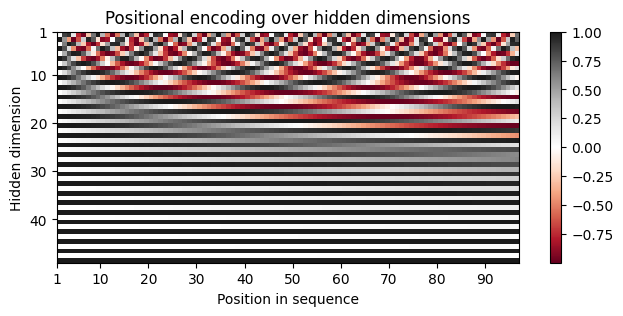

In [8]:
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1, pe.shape[1] + 1, pe.shape[0] + 1, 1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1] + [i * 10 for i in range(1, 1 + pe.shape[1] // 10)])
ax.set_yticks([1] + [i * 10 for i in range(1, 1 + pe.shape[0] // 10)])
plt.show()

### Transformer Encoder Classifier

Finally, we can implement a template for a classifier based on the Transformer encoder.

Additionally to the Transformer architecture, we add:
* a small input network (maps input dimensions to model dimensions)
* the positional encoding
* an output network (transforming output encodings to predictions).

Notice that the output network will take in input a 3D tensor `<batch_samples, seq_len, model_dim>` and produces in output another 2D tensor `<batch_samples, seq_len>` where each output value represents the prediction of the corresponding reversed number.

In [9]:
class TransformerPredictor(nn.Module):
    def __init__(
        self,
        input_dim,
        model_dim,
        num_classes,
        num_heads,
        num_layers,
        dropout=0.0,
        input_dropout=0.0,
    ):
        """
        Args:
            input_dim: Hidden dimensionality of the input
            model_dim: Hidden dimensionality to use inside the Transformer
            num_classes: Number of classes to predict per sequence element
            num_heads: Number of heads to use in the Multi-Head Attention blocks
            num_layers: Number of encoder blocks to use.
            lr: Learning rate in the optimizer
            warmup: Number of warmup steps. Usually between 50 and 500
            max_iters: Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout: Dropout to apply inside the model
            input_dropout: Dropout to apply on the input features
        """
        super().__init__()
        self.input_dim = input_dim
        self.model_dim = model_dim
        self.num_classes = num_classes
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout
        self.input_dropout = input_dropout

        #######################
        ### YOUR CODE HERE! ###
        #######################

        # Create a Generic Input Encoder Input dim -> Model dim with input dropout
        self.input_net = nn.Sequential(
            nn.Dropout(self.input_dropout),
            nn.Linear(self.input_dim, self.model_dim)
        )

        # Create positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model = self.model_dim)

        # Create transformer Encoder
        self.transformer = TransformerEncoder(
            num_layers= self.num_layers,
            input_dim= self.model_dim,
            dim_feedforward=2*self.model_dim,
            num_heads=self.num_heads,
            dropout=self.dropout
        )

        # Create output classifier per sequence element Model_dim -> num_classes
        # self.output_net = nn.Sequential(
        #     nn.Linear(model_dim, num_classes),
        #     nn.Softmax(dim=-1)
        #     )

        self.output_net = nn.Sequential(
            nn.Linear(self.model_dim, self.model_dim),
            nn.LayerNorm(self.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout),
            nn.Linear(self.model_dim, self.num_classes)
        )



    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Args:
            x: Input features of shape [Batch, SeqLen, input_dim]
            mask: Mask to apply on the attention outputs (optional)
            add_positional_encoding: If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)

        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)

        #######################
        ###       END       ###
        #######################

        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """Function for extracting the attention matrices of the whole Transformer for a single batch.

        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps



## Experiment: Sequence to Sequence

After having finished the implementation of the Transformer architecture, we can start experimenting.

A Seq-2-Seq task represents a task where the input _and_ the output is a sequence,
not necessarily of the same length.
Popular tasks in this domain include machine translation and summarization.
For this, we usually have a Transformer encoder for interpreting the input sequence,
and a decoder for generating the output in an autoregressive manner.
Here, however, we will go back to a much simpler example task and use only the encoder, since the output length is fixed.
Given a sequence of $N$ numbers between $0$ and $M$, the task is to reverse the input sequence.
In Numpy notation, if our input is $x$, the output should be $x$[::-1].
Although this task sounds very simple, RNNs can have issues with such because the task requires long-term dependencies.
Transformers are built to support such, and hence, we expect it to perform very well.

First, let's create a dataset class below.

In [10]:
class ReverseDataset(data.Dataset):
    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

We create an arbitrary number of random sequences of numbers between 0 and `num_categories-1`.
The label is simply the tensor flipped over the sequence dimension.
We can create the corresponding data loaders below.

In [11]:
dataset = partial(ReverseDataset, 10, 16)
train_dl = data.DataLoader(dataset(50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_dl = data.DataLoader(dataset(1000), batch_size=128)
test_dl = data.DataLoader(dataset(10000), batch_size=128)

Let's look at an arbitrary sample of the dataset:

In [12]:
inp_data, labels = train_dl.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([7, 8, 4, 1, 0, 4, 0, 4, 9, 7, 0, 0, 1, 4, 9, 9])
Labels:     tensor([9, 9, 4, 1, 0, 0, 7, 9, 4, 0, 4, 0, 1, 4, 8, 7])


During training, we pass the input sequence through the Transformer encoder and predict the output for each input token.
We use the standard Cross-Entropy loss to perform this.
Every number is represented as a one-hot vector.
Remember that representing the categories as single scalars decreases the expressiveness of the model extremely
as $0$ and $1$ are not closer related than $0$ and $9$ in our example.
An alternative to a one-hot vector is using a learned embedding vector as it is provided by the PyTorch module `nn.Embedding`.
However, using a one-hot vector with an additional linear layer as in our case has the same effect
as an embedding layer (`self.input_net` maps one-hot vector to a dense vector,
where each row of the weight matrix represents the embedding for a specific category).

To implement the training dynamic, we create a new class inheriting from `TransformerPredictor`
and overwriting the training, validation and test step functions.

In [13]:
def train_step(model, x, y, optim):
    model.train()

    # Fetch data and transform categories to one-hot vectors
    inp_data = F.one_hot(x, num_classes=model.num_classes).float()

    # Perform prediction and calculate loss and accuracy
    preds = model(inp_data, add_positional_encoding=True)
    loss = F.cross_entropy(preds.view(-1, preds.size(-1)), y.view(-1))
    acc = (preds.argmax(dim=-1) == y).float().mean()

    # Backpropagate and update weights
    loss.backward()
    optim.step()
    model.zero_grad()

    return loss, acc

def eval_step(model, x, y):
    with torch.no_grad():
        model.eval()

        # Fetch data and transform categories to one-hot vectors
        inp_data = F.one_hot(x, num_classes=model.num_classes).float()

        # Perform prediction and calculate loss and accuracy
        preds = model(inp_data, add_positional_encoding=True)
        loss = F.cross_entropy(preds.view(-1, preds.size(-1)), y.view(-1))
        acc = (preds.argmax(dim=-1) == y).float().mean()

    return loss, acc


Finally, we can create a training function similar to the one we have seen in previous laboratories. We running for $N$ epochs printing the training and validation loss and saving our best model based on the validation.
Afterward, we test our models on the test set.

In [14]:
def train_model(model, train_loader, val_loader, test_loader,
                optim, epochs=5):
    best_acc = 0.
    pbar = tqdm(range(epochs))
    for e in range(epochs):
        train_loss, train_acc = 0., 0.
        for x, y in train_loader:
            loss, acc = train_step(model, x, y, optim)
            train_loss += loss
            train_acc += acc

        val_loss, val_acc = 0., 0.
        for x, y in val_loader:
            loss, acc = eval_step(model, x, y)
            val_loss += loss
            val_acc += acc

        if val_acc/len(val_loader) > best_acc:
            torch.save(model.state_dict(), "best_model.pt")
            best_acc = val_acc/len(val_loader)

        pbar.update()
        pbar.set_description(f"Train Acc: {train_acc/len(train_loader)* 100:.2f} "
                            f"Train Loss: {train_loss/len(train_loader):.2f} "
                            f"Val Acc: {val_acc/len(val_loader)* 100 :.2f}  "
                            f"Val loss: {val_loss/len(val_loader):.2f} ")

    test_loss, test_acc = 0., 0.
    for x, y in test_loader:
        loss, acc = eval_step(model, x, y)
        test_loss += loss
        test_acc += acc

    print(f"Test accuracy: {test_acc/len(test_loader)*100 :.2f}")

    pbar.close()
    model.load_state_dict(torch.load("best_model.pt"))

    return model

Finally, we can train the model.
In this setup, we will use a single encoder block and a single head in the Multi-Head Attention.
This is chosen because of the simplicity of the task, and in this case, the attention can actually be interpreted
as an "explanation" of the predictions (compared to the other papers above dealing with deep Transformers).

In [15]:
reverse_model = TransformerPredictor(
    input_dim=train_dl.dataset.num_categories,
    model_dim=32,
    num_heads=1,
    num_classes=train_dl.dataset.num_categories,
    num_layers=1,
    dropout=0.0,
)
optimizer = optim.AdamW(reverse_model.parameters(), lr=0.001)

reverse_model = train_model(reverse_model, train_dl, val_dl, test_dl, optimizer)

  0%|          | 0/5 [00:00<?, ?it/s]

Test accuracy: 100.00


<ipython-input-14-52d45045612b>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


As we would have expected, the Transformer can correctly solve the task.
However, how does the attention in the Multi-Head Attention block looks like for an arbitrary input?
Let's try to visualize it below.

In [16]:
data_input, labels = next(iter(val_dl))
inp_data = F.one_hot(data_input, num_classes=reverse_model.num_classes).float()
inp_data = inp_data.to(device)
attention_maps = reverse_model.get_attention_maps(inp_data)

The object `attention_maps` is a list of length $N$ where $N$ is the number of layers.
Each element is a tensor of shape [Batch, Heads, SeqLen, SeqLen], which we can verify below.

In [17]:
attention_maps[0].shape

torch.Size([128, 1, 16, 16])

Next, we will write a plotting function that takes as input the sequences, attention maps, and an index
indicating for which batch element we want to visualize the attention map.
We will create a plot where over rows, we have different layers, while over columns, we show the different heads.
Remember that the softmax has been applied for each row separately.

In [18]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads * fig_size, num_layers * fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin="lower", vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title("Layer %i, Head %i" % (row + 1, column + 1))
    fig.subplots_adjust(hspace=0.5)
    plt.show()

Finally, we can plot the attention map of our trained Transformer on the reverse task:

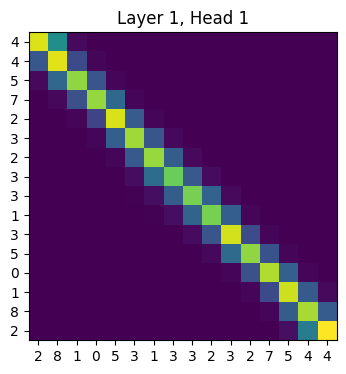

In [19]:
plot_attention_maps(data_input, attention_maps, idx=0)

**Question 6: Is this behavior expected? Why?**

**ANSWER:**
## Key Observations

1. **Successful Learning of Target Behavior**
   - The model has successfully learned to focus on the token positioned at the flipped index relative to itself.
   - This achievement demonstrates that the model has met the intended behavior of the task.

2. **Attention Distribution**
   - Interestingly, the model also allocates some attention to tokens near the flipped index.
   - This suggests a more nuanced attention mechanism than initially expected.

3. **Flexible Attention Structure**
   - The slight attention to nearby indices indicates that the model doesn't require a perfect, rigid attention structure.
   - It performs well even with a more flexible, approximate attention distribution.
   - This flexibility in attention could be beneficial for handling various input patterns.

4. **Alignment with Positional Encoding Design**
   - The attention on neighboring indices results from the similarity in positional encodings for nearby positions.
   - This behavior aligns with the purpose behind the design of the positional encoding in transformer models.
   - It demonstrates that the model is effectively utilizing the continuous nature of the positional information provided.


This observed behavior suggests that the model has learned a robust and adaptable attention mechanism, which could potentially enhance its performance on more complex language tasks.

----------------------------END----------------------------------------